# 1. Linear Regression with custom functions

In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

## 1.1 Generating the Dataset

In [2]:
num_inputs = 2
num_examples = 1000
true_w = torch.tensor([[2, -3.4]]).T
true_b = 4.2
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
labels = features @ true_w + true_b
labels += 0.01 * torch.randn_like(labels, dtype=torch.float32)

print(features[0], labels[0])

tensor([ 0.8207, -0.3953]) tensor([7.1839])


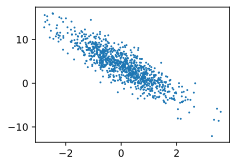

In [3]:
def set_figsize(figsize = (3.5, 2.5)):
    display.set_matplotlib_formats('svg') # display in "svg" format
    plt.rcParams["figure.figsize"] = figsize

set_figsize()
plt.scatter(features[:, 1], labels, 1)

## 1.2 Reading the Dataset


In [4]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) 
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i:min(i + batch_size, num_examples)]) # datatype of the element is `long`
        yield features.index_select(0, j), labels.index_select(0, j)

In [5]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X,"\n", y)
    break

tensor([[-0.8158, -0.2410],
        [-0.5094,  0.2051],
        [-1.7576, -1.0426],
        [-0.2475, -1.1125],
        [-0.2916, -0.8377],
        [ 0.6854, -0.5639],
        [ 0.8196,  1.1823],
        [ 0.4465, -0.3065],
        [-1.1316,  0.7647],
        [ 0.0349,  0.3081]]) 
 tensor([[ 3.3722],
        [ 2.4727],
        [ 4.2450],
        [ 7.4934],
        [ 6.4604],
        [ 7.4778],
        [ 1.8147],
        [ 6.1347],
        [-0.6698],
        [ 3.2077]])


## 1.3 Initializaing Model Parameters

In [6]:
w = torch.normal(0, 0.01, (2, 1))
b = torch.zeros(1, dtype=torch.float32)

In [7]:
w.requires_grad_(True)
b.requires_grad_(True)

tensor([0.], requires_grad=True)

## 1.4 Defining the Model

In [8]:
def linreg(X, w, b):
    assert X.shape[1] == w.shape[0]
    assert w.shape[1] == b.shape[0]
    return torch.mm(X, w) + b # matrix multiplication

## 1.5 Defining the Loss Function

In [9]:
def squared_loss(y_hat, y):
    # return a loss vector with the same shape as y_hat
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

##  1.6 Defining the Optimization Algorithm

In [10]:
def sgd(params, lr, batch_size):
    for param in params:
        # only change value and will not be tracked
        param.data -= lr * param.grad / batch_size

## 1.7 Training

In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()
        l.backward()
        sgd([w, b], lr, batch_size)

        # After each batch we need to clear the previous gradient
        w.grad.data.zero_()
        b.grad.data.zero_()
    # training loss after each epoch for each instance
    train_l = loss(net(features, w, b), labels)
    print("epoch %d, loss %f" % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.045388
epoch 2, loss 0.000182
epoch 3, loss 0.000052


In [12]:
print(true_w, '\n', w)
print(true_b, '\n', b)

tensor([[ 2.0000],
        [-3.4000]]) 
 tensor([[ 2.0001],
        [-3.3994]], requires_grad=True)
4.2 
 tensor([4.1991], requires_grad=True)


# 2 Line Regression with Pytorch
## 2.1 Generating the Dataset

In [13]:
num_inputs = 2
num_examples = 1000
true_w = torch.tensor([[2, -3.4]]).T
true_b = 4.2
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
labels = features @ true_w + true_b
labels += 0.01 * torch.randn_like(labels, dtype=torch.float32)

## 2.2 Reading the Dataset

In [14]:
import torch.utils.data as Data

batch_size = 10
# combine the features and labels
dataset = Data.TensorDataset(features, labels)
# shuffle and read data in batch
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

In [15]:
for X, y in data_iter:
    print(X, "\n", y)
    break

tensor([[-1.3749,  1.1767],
        [-0.6490,  0.2902],
        [ 1.4399,  0.6527],
        [ 0.6110,  0.6656],
        [-1.6502,  0.8700],
        [-0.7501, -1.7752],
        [-0.3108, -1.0342],
        [-1.6439, -0.4656],
        [-0.8127,  0.8807],
        [-0.8308,  1.2148]]) 
 tensor([[-2.5492],
        [ 1.9213],
        [ 4.8536],
        [ 3.1662],
        [-2.0508],
        [ 8.7446],
        [ 7.0824],
        [ 2.4988],
        [-0.4079],
        [-1.5894]])


## 2.3 Defining the Model

In [16]:
import torch.nn as nn

class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        # linear Model
        self.linear = nn.Linear(n_feature, 1)
    
    def forward(self, x):
        y = self.linear(x)
        return y
net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [17]:
# view the parameters
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[0.1013, 0.6110]], requires_grad=True)
Parameter containing:
tensor([-0.5485], requires_grad=True)


## 2.4 Initializing Model Parameters 

In [18]:
from torch.nn import init
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0) # initialize b as 0

Parameter containing:
tensor([0.], requires_grad=True)

## 2.5 Defining the Loss Function

In [19]:
loss = nn.MSELoss()

## 2.6 Defining the Optimization Algorithm

In [20]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [21]:
# Or set different subnet with different learning rate
class FCNet(nn.Module):
    def __init__(self, n_feature):
        super(FCNet, self).__init__()
        # linear Model
        self.subnet1 = nn.Linear(n_feature, 10)
        self.subnet2 = nn.Linear(10, 1)
    
    def forward(self, x):
        y = self.subnet1(x)
        z = self.subnet2(y)
        return z
net2 = FCNet(num_inputs)
optimizer2 = optim.SGD([
    {"params": net2.subnet1.parameters()}, # lr = 0.03
    {"params": net2.subnet2.parameters(), "lr":0.01}
], lr = 0.03)

print(optimizer2)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [22]:
# change the learning rate
for param_group in optimizer2.param_groups:
    param_group["lr"] *= 0.1
print(optimizer2)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)


## 2.7 Training

In [23]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # equivalent to net.zeor_grad()
        l.backward()
        optimizer.step() # optimize per batch
    print("epoch %d, loss: %f" % (epoch + 1, l.item()))

epoch 1, loss: 0.000428
epoch 2, loss: 0.000162
epoch 3, loss: 0.000175


In [24]:
dense = net.linear
print(true_w, dense.weight)
print(true_b, dense.bias)

tensor([[ 2.0000],
        [-3.4000]]) Parameter containing:
tensor([[ 1.9999, -3.3999]], requires_grad=True)
4.2 Parameter containing:
tensor([4.2002], requires_grad=True)


# 4 Softmax Regression on Fashion-MNIST

In [25]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import sys
sys.path.append(".")
import dlWithPytorch.utils as dl

## 4.1 Read the dataset

In [26]:
mnist_train = torchvision.datasets.FashionMNIST(root = "./data/FashionMNIST", train = True, download = True, transform = transforms.ToTensor()) # value between 0 and 1

mnist_test = torchvision.datasets.FashionMNIST(root = "./data/FashionMNIST", train = False, download = True, transform = transforms.ToTensor())

In [27]:
print(len(mnist_train), len(mnist_test))

60000 10000


In [28]:
feature, label = mnist_train[0]
print(feature.shape, label)
type(label)

torch.Size([1, 28, 28]) 9


int

## 4.2 Auxiliary function 

In [29]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [30]:
def show_fashion_mnist(images, labels):
    dl.use_svg_display()
    axes, figs = plt.subplots(1, len(images), figsize = (12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

## 4.3 Read in batch

In [31]:
batch_size = 256
# num_workers means how many Processes we use to load data
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=4)

In [32]:
start = time.time()
for X, y in train_iter:
    continue
print("%.2f sec" %(time.time() - start))

2.44 sec


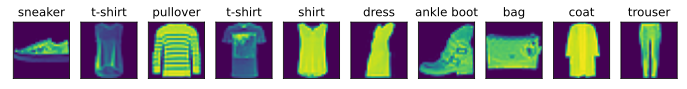

In [33]:
show_fashion_mnist(X[:10], get_fashion_mnist_labels(y[:10]))

## 4.4 Initializing the Model

In [34]:
import torch.nn as nn
num_inputs = 784
num_outputs = 10

class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): #(b,28,28)->(b,784)
        return torch.flatten(x, start_dim=1)
class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        self.flatten = FlattenLayer()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, x):
        y = self.flatten(x)
        z = self.linear(y)
        return z
net = LinearNet(num_inputs, num_outputs)

In [35]:
from torch.nn import init
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0) # initialize b as 0

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

## 4.5 Defining the Softmax and Cross Entropy Loss
`nn.CrossEntropyLoss()` includes both softmax and cross entropy loss

In [36]:
loss = nn.CrossEntropyLoss()

## 4.6 Defining the Optimization Algorithm

In [37]:
optimizer = torch.optim.SGD(net.parameters(), lr = 0.1)

## 4.7 Evaluation

In [38]:
def evaluate_accuracy(data_ier, net):
    acc_sum, n = 0.0, 0
    for X, y in data_ier:
        acc_sum += (net(X).argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    return acc_sum / n


In [39]:
num_epochs = 5
for epoch in range(num_epochs):
    # loss, accuracy and number of instances each epoch
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    test_acc = evaluate_accuracy(test_iter, net)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))


epoch 1, loss 0.0031, train acc 0.748, test acc 0.769
epoch 2, loss 0.0022, train acc 0.813, test acc 0.807
epoch 3, loss 0.0021, train acc 0.825, test acc 0.819
epoch 4, loss 0.0020, train acc 0.832, test acc 0.819
epoch 5, loss 0.0019, train acc 0.838, test acc 0.826
